In [6]:
import torch
from torch_geometric.data import Data
# 方式1 
edge_index = torch.tensor([[0,1,1,2],
                           [1,0,2,1]], dtype=torch.long)
x = torch.tensor([[-1],[0],[1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

# 方式2
edge_index = torch.tensor([[0,1],
                           [1,0],
                           [1,2],
                           [2,1]], dtype=torch.long)
x = torch.tensor([[-1],[0],[1]], dtype=torch.float)
# 将edge_index转化为方式1的shape=[2, edge_num]
data = Data(x=x, edge_index=edge_index.t().contiguous())


In [ ]:
# 自带的数据样例
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./data/Cora', name='Cora')
# 直接 git clone https://github.com/kimiyoung/planetoid.git 将data数据放到root目录的raw中即可

In [14]:
print(f'====== 数据整体预览 =======')
print(f'Dataset 图的个数：{len(dataset)}')
print(f'Dataset 分类个数：{dataset.num_classes}')
print(f'Dataset 节点数据特征：{dataset.num_node_features}')
print(f'Dataset 边数据特征: {dataset.num_edge_features}')
print(f'====== 图数据预览 =======')
print(f'图数据：{str(dataset[0])}')
print(f'图数据-是否为无向图：{dataset[0].is_undirected()}')
print(f'图数据-用于训练节点数量：{dataset[0].train_mask.sum().item()}')
print(f'图数据-用于验证节点数量：{dataset[0].val_mask.sum().item()}')
print(f'图数据-用于测试节点数量：{dataset[0].test_mask.sum().item()}')

====== 数据整体预览 =======
Dataset 图的个数：1
Dataset 分类个数：7
Dataset 节点数据特征：1433
Dataset 边数据特征: 0
====== 图数据预览 =======
图数据：Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
图数据-是否为无向图：True
图数据-用于训练节点数量：140
图数据-用于验证节点数量：500
图数据-用于测试节点数量：1000


### PyG中Mini-Batch并行机制
PyG 通过创新的"稀疏块对角邻接矩阵"和节点特征拼接技术实现了图数据的 mini-batch 并行处理。这种设计使得不同大小和结构的图可以高效地组合在一起处理。下面我将详细解释这个过程：  
核心思想：虚拟大图表示  
1. **邻接矩阵**： 每个图的邻接矩阵作为大图的快对角部分  
2. **节点特征**: 所有图的特征沿节点维度连接  
3. **图隔离**: 不同图之间没有边连接  
假设现在有2个子图：  
图1： A-B， B-C  
图2： D-E  
```shell
     A B C  |       D   E
 A   0 1 0  |   D   0   1
 B   1 0 1  |   E   1   0
 C   0 1 0  |
```
在pyG中步骤如下：  
1. 重新索引； 2. 节点特征拼接； 3. batch跟踪向量
```python
# 步骤1：
edge_index = torch.tensor([
    [0, 1, 1, 2, 3, 4],  # 源节点
    [1, 0, 2, 1, 4, 3]   # 目标节点
], dtype=torch.long)
# 步骤2：
x1 = torch.tensor([[0.1, 0.2], [0.3, 0.4], [0.5, 0.6]])  # 图1节点特征
x2 = torch.tensor([[0.7, 0.8], [0.9, 1.0]])              # 图2节点特征
x_batch = torch.cat([x1, x2], dim=0)  # 连接后特征矩阵
# 步骤3：
batch = torch.tensor([0, 0, 0, 1, 1])  # 前3个节点属于图1，后2个属于图2
```
消息传递的工作机制：  
当图神经网络中进行消息传递时：  
1. 邻接矩阵隔离：块对角结构确保消息只在同一个图的节点间传递  
2. 并行计算：所有节点同时参与计算，GPU可高效并行处理  
3. 结果分离：使用Batch向量可分离不同图的结果

In [ ]:
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

dataset = TUDataset(root='./data/ENZYMES', name='ENZYMES', use_node_attr=True)
loader = DataLoader(dataset=dataset, batch_size=32, shuffle=True)

Processing...
Done!


ENZYMES数据集是在GNN领域是非常经典的数据集，它是一个根据生物分子蛋白质结构而构建的Graph数据集合，总共600个图，也就是对应600个样本（蛋白质分子） ，共有六种结构

这个数据集是一个用于图级分类任务的数据，该数据集中共有 600张图，含有 19580个节点， 174564条边，每个节点的 特征维度为3。

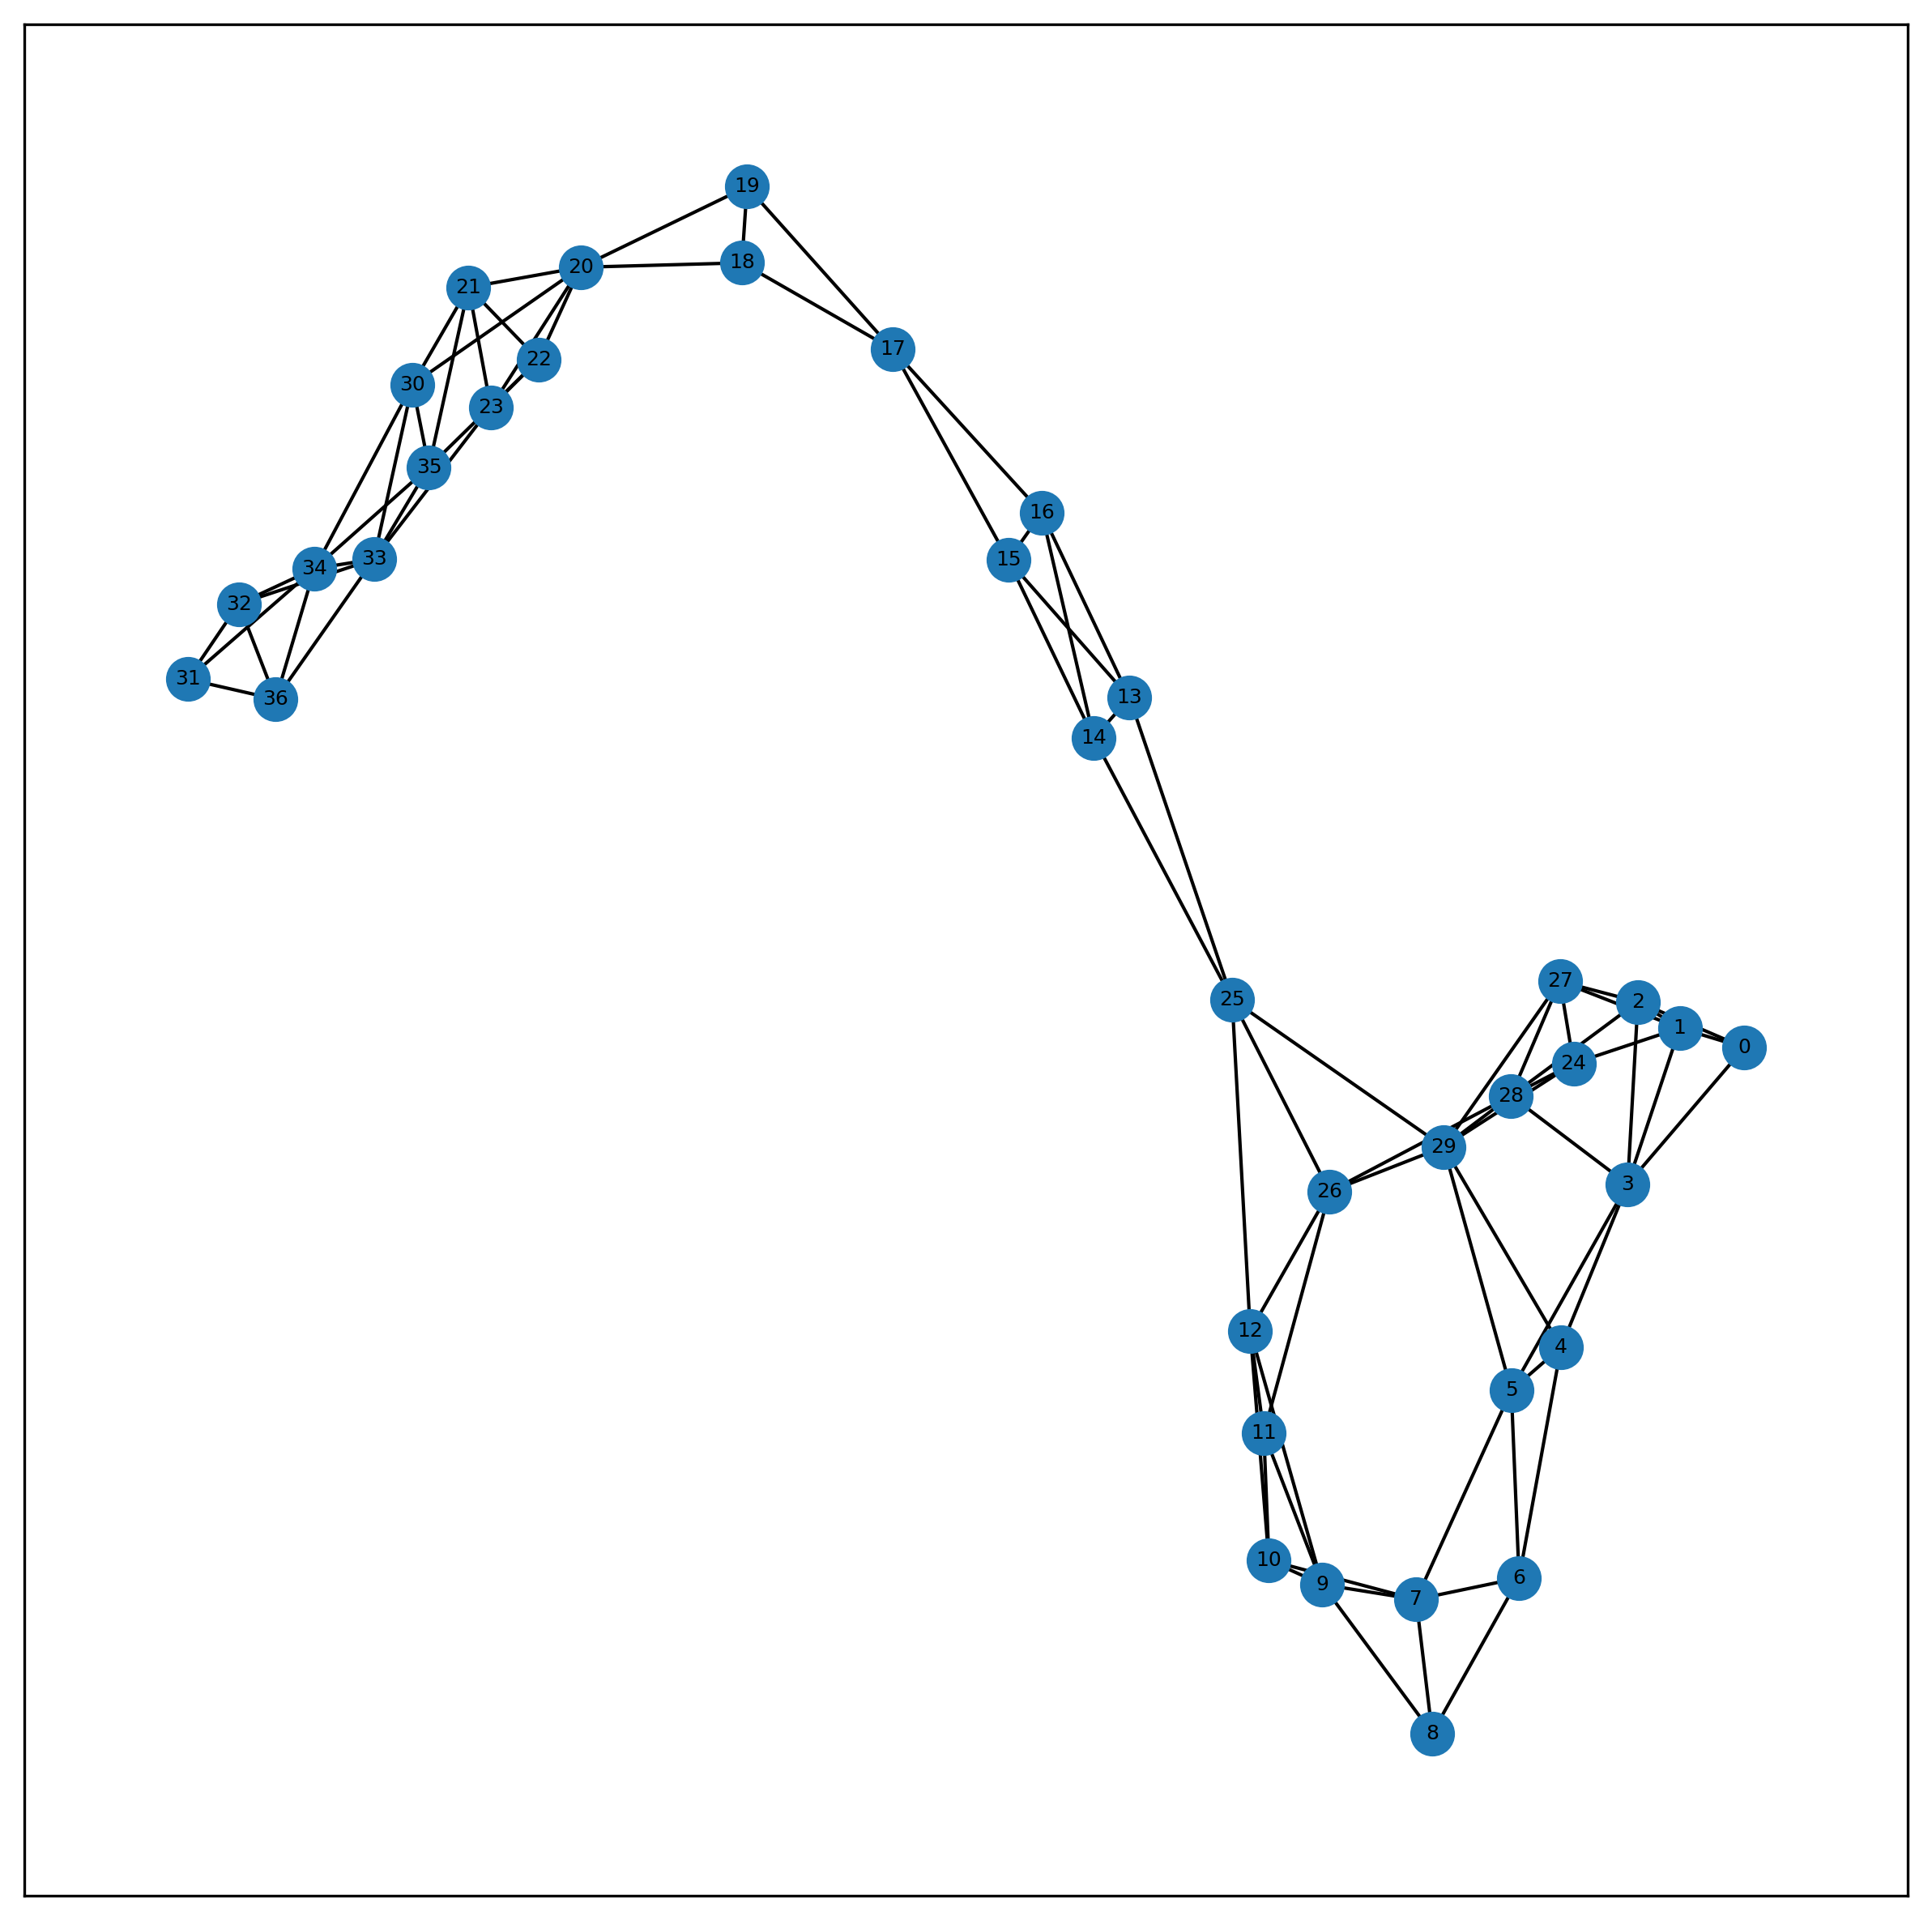

In [17]:
import matplotlib.pyplot as plt
import networkx as nx
# 下面可视化第一个子图
graph = nx.Graph()
edge_index = dataset[0].edge_index
source_node = edge_index[0] # 起点
target_node = edge_index[1] # 终点

for src, tge in zip(source_node, target_node):
    graph.add_edge(src.item(), tge.item())

# 可视化
plt.rcParams['figure.dpi'] = 300 # 设置分辨率
fig, ax1 = plt.subplots(figsize=(10,10))
nx.draw_networkx(G=graph, ax=ax1, font_size=6, node_size=150)
plt.show()

### 对节点的属性聚合计算
在一个大图中，存在多个子图。通常需要根据子图分组，然后对每个节点的每个维度进行聚合计算（avg,sum,max,min）等。  
相当于如下操作:  
```sql
select subGraphId, avg(c1) as avgC1, min(c2) as minC2 from bigGraph
group by subGraphId;
```
在pyG的代码如下：
```python
x = scatter(data.x, data.batch, dim=0, reduce='mean')
```

In [21]:
from torch_geometric.utils import scatter
for data in loader:
    print(f'整体数据: {str(data)}')
    print(f'子图数量：{data.num_graphs}')
    x = scatter(data.x, data.batch, dim=0, reduce='mean')
    print(f'聚合操作后Shape: {x.size()}')
    break

整体数据: DataBatch(edge_index=[2, 3744], x=[932, 21], y=[32], batch=[932], ptr=[33])
子图数量：32
聚合操作后Shape: torch.Size([32, 21])


## PyG上的图学习方法
现在用来学习一下一个简单的GCN层

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

# 模型定义
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)
    
    def forward(self, data:Data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)
    
# 训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN.to(device)
data = dataset[0].to(device)

## 定义优化op
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

## 拿出1个数据，迭代训练200次
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

# 验证模型
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'准确率：{acc:.4f}')